## Experiment 3
<br>
-- Combination of raw numbers and katakana characters



In [1]:
import json
import re
import data_handler as dh
import utils

from collections import defaultdict
from itertools import product
from IPython.display import clear_output

import pandas as pd
import numpy as np

2023-01-05 13:58:48.873875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 13:58:49.866908: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-01-05 13:58:49.866968: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-01-05 13:58:49.866973: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] 

### Data setting

In [2]:
data_path = '/home/donghyun/eye_writing_classification/v2_dataset/200_points_dataset/'

with open(data_path + 'eog_raw_numbers_200.json') as f:
  eog_raw_numbers = json.load(f)

with open(data_path + 'eog_katakana_200.json') as f:
  eog_katakana = json.load(f)

with open(data_path + 'reference_data_200.json') as f:
  reference_data = json.load(f)

In [3]:
print(eog_katakana.keys())
print(eog_raw_numbers.keys())

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])


In [4]:
# katakana class를 10~21으로 치환 후 merge

katakana_le = {'1':'10', '2':'11', '3':'12', '4':'13', '5':'14',
               '6':'15', '7':'16', '8':'17', '9':'18', '10':'19',
               '11':'20', '12':'21'}

all_data = eog_raw_numbers.copy()
for k in eog_katakana.keys():
    cnvt_key = katakana_le[k]
    all_data[cnvt_key] = eog_katakana[k]

all_ref = defaultdict()
all_ref['all'] = reference_data['numbers'].copy()
for k in reference_data['katakana'].keys():
    cnvt_key = katakana_le[k]
    all_ref['all'][cnvt_key] = reference_data['katakana'][k]


print(all_data.keys())
print(np.array(all_data['0']).shape)
print(np.array(all_data['11']).shape)
print(all_ref.keys())
print(all_ref['all'].keys())
print(np.array(all_ref['all']['0']).shape)
print(np.array(all_ref['all']['11']).shape)

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'])
(54, 200, 2)
(60, 200, 2)
dict_keys(['all'])
dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'])
(1, 200, 2)
(1, 200, 2)


In [5]:
save_path = '/home/donghyun/eye_writing_classification/experiments/save/'

best_perform_df = pd.read_csv(save_path + 'experiment2_vit_hyperparams.csv')

### Experiment

In [6]:
# Config class

class Config:
    split_ratio = 0.3
    ref_key = 'all'
    batch_size = 22            # fix : must be equaled with number of test pairs 
    n_batch = 100
    lr = 0.0001                 # default learning rate
    model_type = 'ViTBaseModel'
    ViT_params = {}
    epochs = 100

#### learning with hyperparameters of previous experiment

In [ ]:
cfg = Config()

cfg.ViT_params = best_perform_df.iloc[0].to_dict()
cfg.ViT_params['mlp_units'] = re.sub('[\[\]]','',cfg.ViT_params['mlp_units'])
cfg.ViT_params['mlp_units'] = list(map(int,cfg.ViT_params['mlp_units'].split(',')))       # str to list
cfg.ViT_params['batch_size'] = cfg.batch_size

vit_dict = defaultdict(list)
bybrid_dict = defaultdict(list)

times = 10
for t in range(times):
    _, vit_train_acc, vit_train_loss, vit_test_acc = utils.experiment(cfg, all_data, all_ref, zero_shot_cls=None)
    vit_dict[t] = [vit_train_acc, vit_train_loss, vit_test_acc]

In [ ]:
# results save
save_path = '/home/donghyun/eye_writing_classification/experiments/save/'

with open(save_path + 'experiment3_all_prev_params_results.json', 'w') as f:
    json.dump(dict(vit_dict),f)

#### Searching the new hyperparameters

In [6]:
# new hyperparameters list

vit_hidden_size = [128,256,512]
vit_patch_size = [5,10]
vit_heads = [8,16]
vit_n_layers = [12,16]
vit_mlp_units = [[256,128],
                 [128,64]]
vit_dropout = [0]
vit_mlp_dropout = [0]

In [ ]:
# grid search for hyperparameters

cols = ['hidden_size', 'batch_size', 'patch_size', 'heads', 'n_layers', 'mlp_units', 'dropout', 'mlp_dropout', 'score']
best_perform_df = pd.DataFrame(columns=cols)

i = 0
for hs, ps, heads, n_layers, mlp_units, dropout, mlp_dropout in product(vit_hidden_size,
                                                                            vit_patch_size,
                                                                            vit_heads,
                                                                            vit_n_layers,
                                                                            vit_mlp_units,
                                                                            vit_dropout,
                                                                            vit_mlp_dropout
                                                                            ):
    i+=1
    print('index : ', i)

    cfg = Config()

    cfg.ViT_params['hidden_size'] = hs
    cfg.ViT_params['batch_size'] = cfg.batch_size
    cfg.ViT_params['patch_size'] = ps
    cfg.ViT_params['heads'] = heads
    cfg.ViT_params['n_layers'] = n_layers
    cfg.ViT_params['mlp_units'] = mlp_units
    cfg.ViT_params['dropout'] = dropout
    cfg.ViT_params['mlp_dropout'] = mlp_dropout

    _, _, _, test_acc_list = utils.experiment(cfg, all_data, all_ref)
    score = np.mean(test_acc_list[-3:])

    best_perform_df.loc[i] = [hs, cfg.batch_size, ps, heads, n_layers, str(mlp_units), dropout, mlp_dropout, score]

best_perform_df = best_perform_df.sort_values(by='score',ascending=False)

In [11]:
# hyperparameters save

save_path = '/home/donghyun/eye_writing_classification/experiments/save/'
best_perform_df.to_csv(save_path+'experiment3_new_hyperparams.csv', index=True)

In [5]:
# load the hyperparameters

save_path = '/home/donghyun/eye_writing_classification/experiments/save/'
best_perform_df = pd.read_csv(save_path+'experiment3_new_hyperparams.csv')

best_perform_df.head(10)

,Unnamed: 0,hidden_size,batch_size,patch_size,heads,n_layers,mlp_units,dropout,mlp_dropout,score
0,9,128,22,10,8,12,"[256, 128]",0,0,82.890071
1,24,256,22,5,16,16,"[128, 64]",0,0,81.117021
2,7,128,22,5,16,16,"[256, 128]",0,0,81.117021
3,2,128,22,5,8,12,"[128, 64]",0,0,80.762411
4,13,128,22,10,16,12,"[256, 128]",0,0,79.521277
5,1,128,22,5,8,12,"[256, 128]",0,0,78.457447
6,3,128,22,5,8,16,"[256, 128]",0,0,77.570922
7,10,128,22,10,8,12,"[128, 64]",0,0,77.482270
8,5,128,22,5,16,12,"[256, 128]",0,0,76.861702
9,14,128,22,10,16,12,"[128, 64]",0,0,75.797872


In [13]:
best_params = best_perform_df.iloc[0].to_dict()
best_params['mlp_units'] = re.sub('[\[\]]','',best_params['mlp_units'])
best_params['mlp_units'] = list(map(int,best_params['mlp_units'].split(',')))       # str to list

cfg = Config
cfg.ViT_params = best_params

times = 10
vit_all_result = defaultdict(list)
for t in range(times):
    _, all_train_acc, all_train_loss, all_test_acc = utils.experiment(cfg, all_data, all_ref)
    vit_all_result[t] = [all_train_acc, all_train_loss, all_test_acc]

epoch : 1, train acc : 63.2727 %, train loss : 0.61447159, test acc : 22.6064 %, 
epoch : 2, train acc : 70.0455 %, train loss : 0.54801458, test acc : 25.0000 %, 
epoch : 3, train acc : 74.7727 %, train loss : 0.52418069, test acc : 35.1064 %, 
epoch : 4, train acc : 76.9545 %, train loss : 0.50011623, test acc : 26.0638 %, 
epoch : 5, train acc : 77.4545 %, train loss : 0.48289696, test acc : 37.5000 %, 
epoch : 6, train acc : 79.6818 %, train loss : 0.47169946, test acc : 32.1809 %, 
epoch : 7, train acc : 81.7273 %, train loss : 0.43563806, test acc : 43.3511 %, 
epoch : 8, train acc : 84.0000 %, train loss : 0.40419878, test acc : 43.0851 %, 
epoch : 9, train acc : 84.3182 %, train loss : 0.40370115, test acc : 41.7553 %, 
epoch : 10, train acc : 86.1818 %, train loss : 0.36108506, test acc : 45.4787 %, 
epoch : 11, train acc : 85.3636 %, train loss : 0.38170449, test acc : 47.8723 %, 
epoch : 12, train acc : 87.3182 %, train loss : 0.33567743, test acc : 49.4681 %, 
epoch : 13, t

In [14]:
# save the result

with open(save_path + 'experiment3_all_new_params_results.json', 'w') as f:
    json.dump(dict(vit_all_result),f)

### Visualization

In [6]:
save_path = '/home/donghyun/eye_writing_classification/experiments/save/'

with open(save_path+'experiment3_all_prev_params_results.json') as f:
    all_prev_results = json.load(f)

with open(save_path+'experiment3_all_new_params_results.json') as f:
    all_new_results = json.load(f)

In [7]:
prev_test_acc = []
new_test_acc = []
for t in range(10):
    key = str(t)
    prev = list(map(int, all_prev_results[key][2]))
    new = list(map(int, all_new_results[key][2]))
    prev_test_acc.append(prev)
    new_test_acc.append(new)

prev_avg_results = np.array(prev_test_acc).mean(axis=0)
new_avg_results  =np.array(new_test_acc).mean(axis=0)

In [9]:
def analysis(data_list):
    return np.mean(data_list), max(data_list), min(data_list), np.std(data_list)

prev_all_test_performance = [t[-1] for t in prev_test_acc]
new_all_test_performance = [t[-1] for t in new_test_acc]

print('Accuracy base on raw numbers with 10 repetitions')
print(' '*29 +'1,     2,    3,      4,      5,      6,     7,     8,     9,     10,       Avg.   Best.   Worst.  Std.')
print('prev vit model performance : {}, {}'.format(prev_all_test_performance, analysis(prev_all_test_performance)))
print('new vit model performance  : {}, {}'.format(new_all_test_performance, analysis(new_all_test_performance)))

Accuracy base on raw numbers with 10 repetitions
                             1,     2,    3,      4,      5,      6,     7,     8,     9,     10,       Avg.   Best.   Worst.  Std.
prev vit model performance : [77, 81, 81, 77, 77, 77, 79, 78, 79, 82], (78.8, 82, 77, 1.8330302779823362)
new vit model performance  : [79, 79, 79, 81, 78, 78, 79, 80, 78, 81], (79.2, 81, 78, 1.0770329614269007)


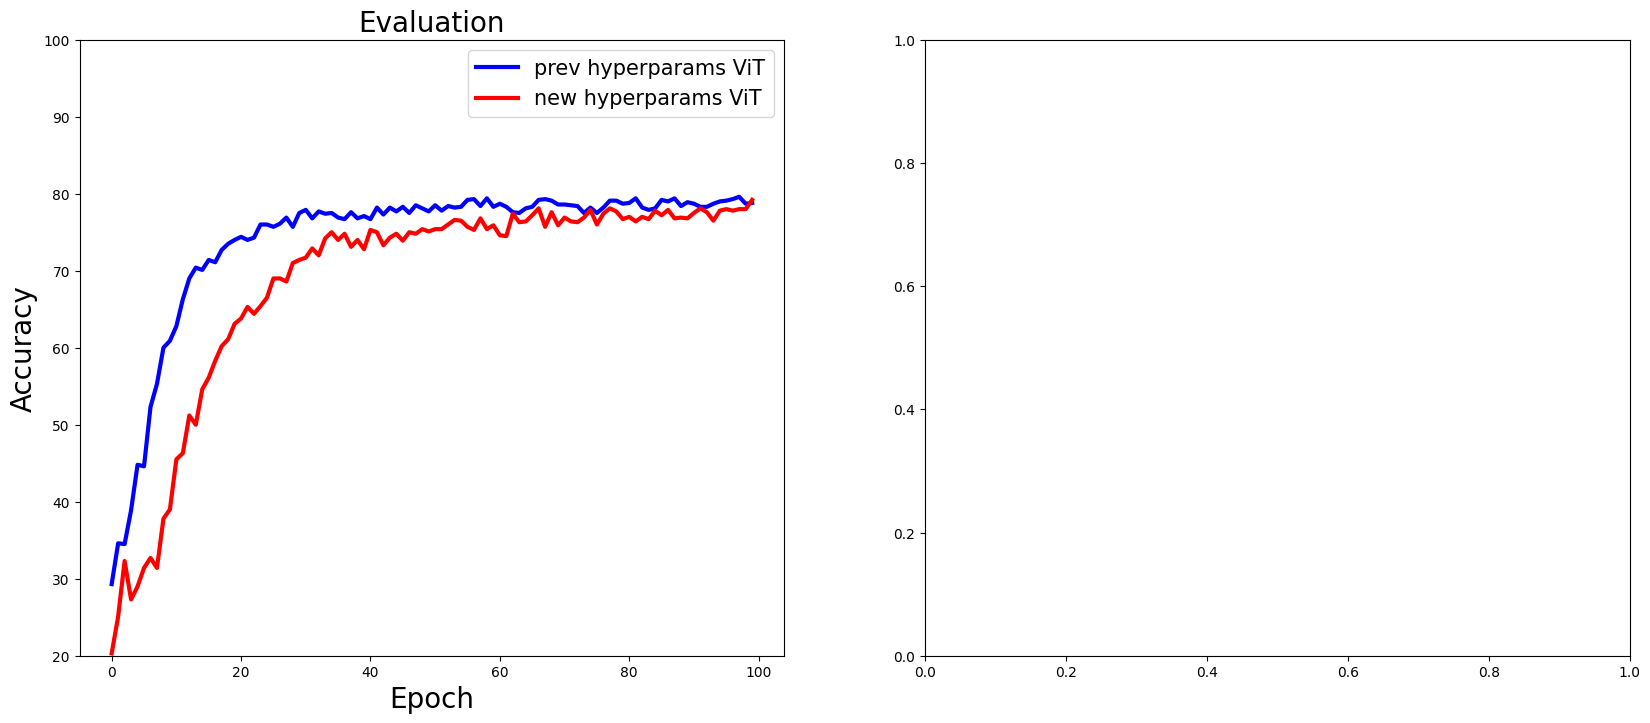

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize = (20,8))

# test accuracy
axes[0].plot(prev_avg_results, c = 'b', linestyle = 'solid', linewidth = 3)
axes[0].plot(new_avg_results, c = 'r', linestyle = 'solid', linewidth = 3)

axes[0].set_ylim(20,100)

axes[0].set_title("Evaluation", fontsize=20)
axes[0].set_xlabel('Epoch', fontsize = 20)
axes[0].set_ylabel('Accuracy', fontsize = 20)

axes[0].legend(['prev hyperparams ViT', 'new hyperparams ViT'], fontsize = 15)

# plot
plt.show()